## Data collection

In [1]:
# import tarfile
# from tqdm import tqdm
# from urllib.request import urlopen
# from io import BytesIO
# from zipfile import ZipFile
# import os

# def download_and_unzip(url, extract_to='Datasets', chunk_size=1024*1024):
#     http_response = urlopen(url)

#     data = b''
#     iterations = http_response.length // chunk_size + 1
#     for _ in tqdm(range(iterations)):
#         data += http_response.read(chunk_size)

#     zipfile = ZipFile(BytesIO(data))
#     zipfile.extractall(path=extract_to)

# dataset_path = os.path.join('Datasets', 'IAM_Words')
# if not os.path.exists(dataset_path):
#     download_and_unzip('https://git.io/J0fjL', extract_to='Datasets')

#     file = tarfile.open(os.path.join(dataset_path, "words.tgz"))
#     file.extractall(os.path.join(dataset_path, "words"))

## Imports

In [40]:
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
import numpy as np
import os

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

## Dataset Preprocessing

In [3]:
base_path = "Datasets\IAM_Words"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

### Spliting
90% training , 5% validation and 5% for testing

In [4]:
train_samples, test_samples = train_test_split(words_list, test_size=0.1, random_state=42)
validation_samples, test_samples = train_test_split(test_samples, test_size=0.5, random_state=42)

# Number of samples in each set
print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [5]:
for i in train_samples[:5]:
    print(i)

n02-120-03-02 ok 182 929 1313 37 25 AT a

g06-026k-02-02 ok 182 884 1102 121 44 RB ever

e07-061-08-07 ok 157 1856 2179 147 66 HVD had

e04-019-01-07 ok 173 1939 920 223 104 NN choice

g06-105-03-04 ok 188 1263 1313 122 48 JJB main



### Getting Image path & Clean label

e04-019-01-07 ok 173 1939 920 223 104 NN choice

Here destination folder is words/e04/e04-019/e04-019-01-07.png -> choice

choice is the label


In [6]:
base_image_path = os.path.join(base_path, "words")

def get_image_paths_and_labels(samples):
    paths = []
    labels = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        image_name = line_split[0]
        folder_1 = image_name.split("-")[0]
        folder_2 = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, folder_1, folder_1 + "-" + folder_2, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            labels.append(line_split[-1])

    return paths, labels


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [7]:
train_labels[:10]

['a',
 'ever',
 'had',
 'choice',
 'main',
 'sea-farers',
 'a',
 'animals',
 'his',
 'image']

### Finding max Char in a label and the size of the vocabulary in the training data.

In [8]:
characters = set()
max_len = 0

for label in train_labels:
    for char in label:
        characters.add(char)
    max_len = max(max_len, len(label))

characters = sorted(list(characters))
train_labels_cleaned = train_labels
print("Maximum length: ", max_len)
print("Vocabulary size: ", len(characters))


Maximum length:  21
Vocabulary size:  78


### Building the character vocabulary
Our study involves preprocessing labels at the character level. 

This means that if there are 3 labels "who", "are" and "how" then our character
vocabulary should be {a, e, h, o, r, w}.

We are using the [`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup/) layer for this purpose.

In [9]:

AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

### Images Resizing

Instead of square images, many OCR models work with rectangular images. Here we using rectangular images too.
Because in this case most of the time our words will be in rectangular shape rather then squre.

If we use squre then this will add more padding to our images

By using rectangular image we preserved the aspect ratio and content of the images is not affected too.

In [10]:

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Checking tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # giving same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


### All necessary functions to prepare our data into `tf.data.Dataset` objects

In [11]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


In [12]:
# Converting into tf.data.Dataset object
train_ds = prepare_dataset(train_img_paths, train_labels)
validation_ds = prepare_dataset(validation_img_paths, validation_labels)
test_ds = prepare_dataset(test_img_paths, test_labels)

### Getting real values from a tf.data.Dataset object.

In [13]:
def get_label_in_text (label):
    indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
    # Convert to string.
    label = tf.strings.reduce_join(num_to_char(indices))
    label = label.numpy().decode("utf-8")
    return label

### Visualizing a few samples

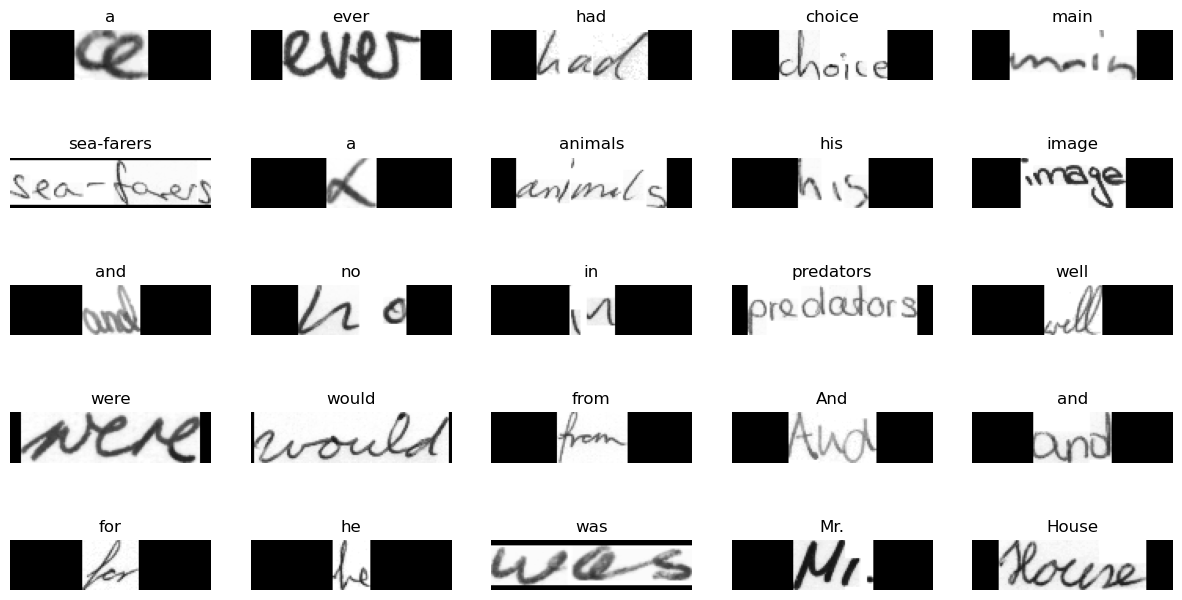

In [61]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(5, 5, figsize=(15, 8))

    for i in range(25):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 5, i % 5].imshow(img, cmap="gray")
        ax[i // 5, i % 5].set_title(label)
        ax[i // 5, i % 5].axis("off")


plt.show()

## Model Build

Our model will use the CTC loss as an endpoint layer.

In [15]:

class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        super(CTCLayer, self).__init__(name=name, **kwargs)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # For test time, just returning the computed predictions.
        return y_pred

    def get_config(self):
        config = super(CTCLayer, self).get_config()
        return config


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2. 
    # Hence, downsampled feature maps are 4x smaller. The number of filters in the last layer is 64. 
    # Reshaping accordingly before passing the output to the RNN part of the model.

    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Adding CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Defining the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()

    # Compiling the model and return.
    model.compile(optimizer=opt)
    return model


# Building the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

### Evaluation Metric -> Edit Distances.

We first segregate the validation images and their labels for convenience.

In [16]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

Now, we create a callback to monitor the edit distances.

In [17]:

def calculate_edit_distance(labels, predictions):
    # Get a single batch and converting its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Making predictions and converting them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Computing individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)

edit_distance_history = []

class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        edit_distance_history.append(np.mean(edit_distances))
        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


## Training

Now we are ready to kick off model training.

In [18]:
epochs = 1

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)


#saving every model weights using Keras checkpoint
from keras.callbacks import ModelCheckpoint
# filepath="checkpoint/check-{epoch:02d}-{val_loss:.4f}.hdf5"
# checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)


# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
    # callbacks=[edit_distance_callback,checkpoint],
)

print(edit_distance_history)

1/1 [==============================] - 3s 3s/step
Mean edit distance for epoch 1: 20.4078
1357/1357 [==============================] - 730s 531ms/step - loss: 13.5716 - val_loss: 12.0071


dict_keys(['loss', 'val_loss'])


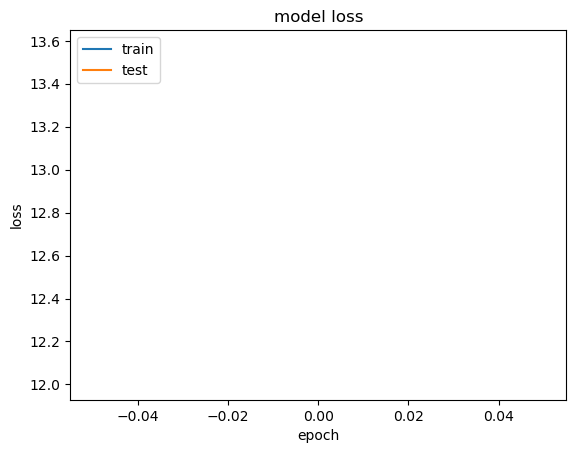

In [58]:
print(history.history.keys())
# ploting history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Saving model

In [55]:
current_date_time = datetime.now()
cdt_string = current_date_time.strftime("%d.%m.%y-%I.%M%p")

epoch = history.params['epochs']

loss = history.history['loss'][-1]
# zfill function add leading zeros so that the str is minimum 6 characters long. Ex: 06.300
loss = "{:.3f}".format(loss).zfill(6) 

model.save(f'Model/model-{epoch:03d}E-{loss}L-{cdt_string}.h5')

## Prediction

### Predicted float -> String / text function

In [34]:
# A utility function to decode the output
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]

    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterating over the results and getting the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


### Load saved model and predict using list of file path

In [37]:
def predict_by_saved_model(image_paths,model_path='model-40.h5'):
    # Loading the saved model
    loaded_model = tf.keras.models.load_model(model_path, custom_objects={'CTCLayer': CTCLayer})

    # Setting the prediction model
    prediction_model = tf.keras.models.Model(
        loaded_model.get_layer(name="image").input, loaded_model.get_layer(name="dense2").output
    )
    predictions = []
    for path in image_paths:
        # Load an image and preprocess it
        image = preprocess_image(path)

        # Make a prediction
        pred = prediction_model.predict(image[np.newaxis, ...])

        # Convert the predictions to text
        predicted_text = decode_batch_predictions(pred)
        predictions.append({path:predicted_text})
    
    return predictions


### Predicting some with predict_by_saved_model function

In [52]:

image_paths = ['Datasets/IAM_Words/words/a03/a03-006/a03-006-00-00.png','Datasets/IAM_Words/words/a03/a03-006/a03-006-01-01.png','Datasets/IAM_Words/words/a03/a03-006/a03-006-02-00.png','Datasets/IAM_Words/words/a03/a03-006/a03-006-06-03.png',]

x = predict_by_saved_model(image_paths)
print(x)



1/1 [==============================] - 0s 34ms/step
[{'Datasets/IAM_Words/words/a03/a03-006/a03-006-00-00.png': ['Today']}, {'Datasets/IAM_Words/words/a03/a03-006/a03-006-01-01.png': ['arrived']}, {'Datasets/IAM_Words/words/a03/a03-006/a03-006-02-00.png': ['Foreign']}, {'Datasets/IAM_Words/words/a03/a03-006/a03-006-06-03.png': ['any']}]


## Testing

In [95]:
t_true = []
t_pred = []
t_img = []

for batch in test_ds.take(1):
    batch_images = batch["image"]
    batch_label = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    for i in range(len(batch_images)):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        actual_text = get_label_in_text(batch_label[i])
        t_true.append(actual_text)
        t_pred.append(pred_texts[i])
        t_img.append(img)
        print(t_true[-1])


plt.show()

2/2 [==============================] - 0s 57ms/step
,
are
which
much
headed
of
homicidal
?
facilities
He
ft.
last
Duke
better
at
to
,
,
and
of
as
lively
cinema
in
in
grounds
beer
,
to
p.m.
Earl
to
before
go
cent
as
of
set
has
needed
was
fall
-
gather
to
country
than
Imperial
most
cook
fears
seems
could
for
with
are
He
:
could
that
,
.
policy
and


### Accuracy Calculator

In [76]:
def calculate_accuracy_char(true,prediction):

    min_len = min( len(true), len(prediction) )

    for i in range( min_len ):
        for j in range( min( len( true[i] ), len( prediction[i] ) ) ):
            pass



def calculate_accuracy(true,prediction):
    count = 0
    min_len = min( len(true), len(prediction) )

    for i in range( min_len ):
        if true[i].lower() == prediction[i].lower():
            count+=1
    return count/min_len

In [90]:
acc = calculate_accuracy(t_true, t_pred)
print('Test Data Size : ',len(t_true))
print('Accuracy : ',acc*100,'%')

Test Data Size :  4823
Accuracy :  73.9166493883475 %


### Plotting The Predictions

In [127]:
def plot_prediction(true, prediction, images, row=6, column=4, figsize=(16, 9)):
    
    min_len = min( len(true), len(prediction), len(images) )
    _, ax = plt.subplots(row, column, figsize=figsize)
    
    for i in range(min_len):
        if(i<row*column):
            title = f"Real = {true[i]} || Pred = {prediction[i]}"
            ax[i //column, i % column].imshow(images[i], cmap="gray")
            ax[i //column, i % column].set_title(title)
            ax[i //column, i % column].axis("off")

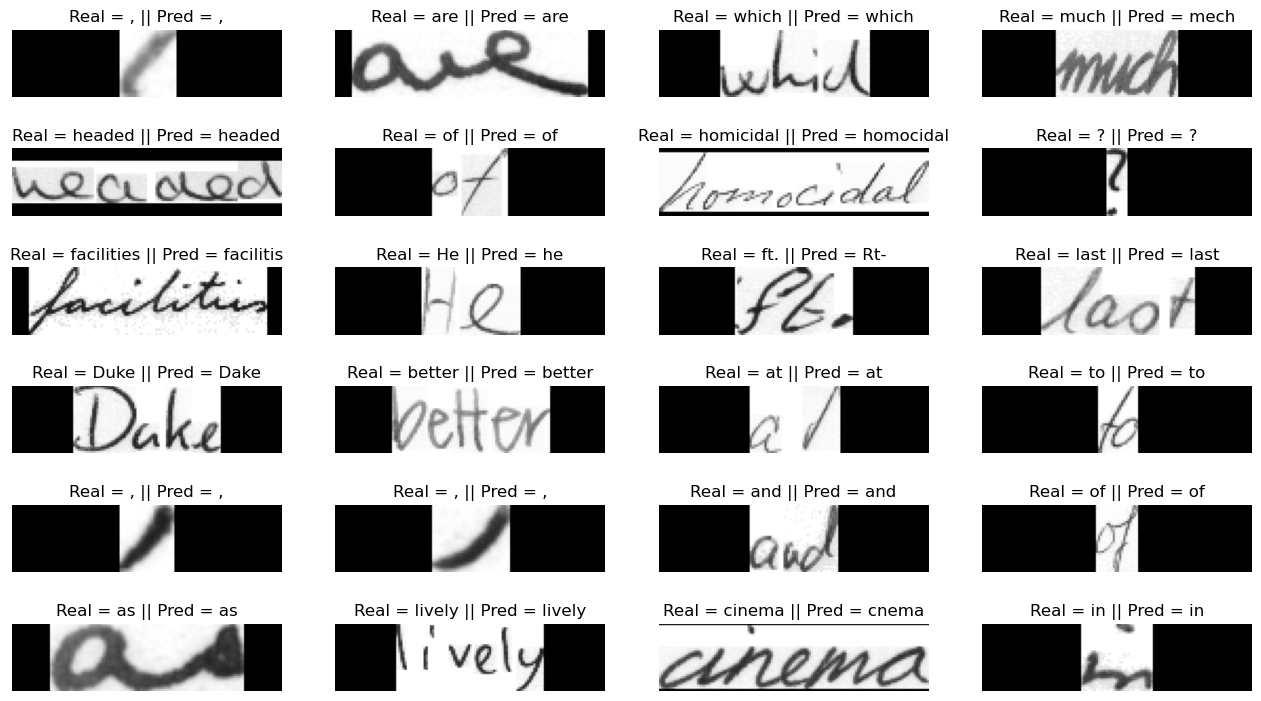

In [128]:
plot_prediction(t_true[:24],t_pred[:24],t_img[:24])